In [1]:
import io
from google.colab import files
uploaded = files.upload()

Saving twitter_sentiment_data.csv to twitter_sentiment_data (1).csv


In [2]:
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['twitter_sentiment_data (1).csv']))

In [ ]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [ ]:
df.columns

Index(['sentiment', 'message', 'tweetid'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [ ]:
df.shape

(43943, 3)

In [ ]:
print(df.isna().sum()) # Fortunately, this dataset has no missing values.

sentiment    0
message      0
tweetid      0
dtype: int64


In [ ]:
print(df['sentiment'].unique())

# 0 --> Neutral / 1 --> Beliefs in climate change / 2 --> Factual news / -1 --> No belief in climate change 

[-1  1  2  0]


# Data Analytics)
1- Calculate tweet lengths and compare them by sentiment.

In [3]:
# Calculate the length of each tweet
df['tweet_length'] = df['message'].apply(len)

# Group by sentiment and calculate average tweet length
avg_tweet_length_by_sentiment = df.groupby('sentiment')['tweet_length'].mean()

print(avg_tweet_length_by_sentiment)

sentiment
-1    123.963158
 0    110.728062
 1    128.002700
 2    119.574709
Name: tweet_length, dtype: float64


2- Identify links in tweets and calculate the number of links per tweet.

In [4]:
import pandas as pd
import re

# Function to extract URLs
def extract_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    urls = url_pattern.findall(text)
    return urls

df['urls'] = df['message'].apply(extract_urls)

# Function to count URLs
def count_urls(urls):
    return len(urls)

df['url_count'] = df['urls'].apply(count_urls)

print(df['url_count'])


0        0
1        1
2        1
3        1
4        0
        ..
43938    1
43939    0
43940    1
43941    0
43942    0
Name: url_count, Length: 43943, dtype: int64


In [ ]:
print(df['url_count'].head(20))

0     0
1     1
2     1
3     1
4     0
5     1
6     0
7     0
8     2
9     1
10    1
11    1
12    1
13    0
14    2
15    0
16    0
17    2
18    1
19    1
Name: url_count, dtype: int64


In [ ]:
print(df['url_count'].tail(20))

43923    0
43924    0
43925    1
43926    1
43927    0
43928    1
43929    1
43930    1
43931    2
43932    0
43933    1
43934    1
43935    1
43936    0
43937    1
43938    1
43939    0
43940    1
43941    0
43942    0
Name: url_count, dtype: int64


3- Check for correlation between sentiment and text length and number of links.

             sentiment  text_length  url_count
sentiment     1.000000     0.058337   0.307103
text_length   0.058337     1.000000   0.023926
url_count     0.307103     0.023926   1.000000


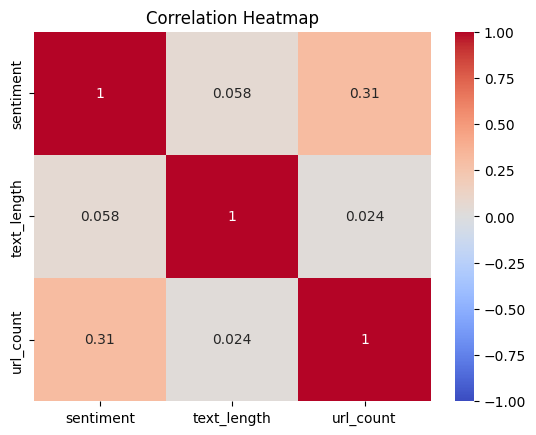

In [5]:
# Calculate the length of each message
df['text_length'] = df['message'].apply(len)

# Correlation
correlation_matrix = df[['sentiment', 'text_length', 'url_count']].corr()
print(correlation_matrix)

# Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlation Heatmap')
plt.show()

# NER (Named Entity Recognition)
Use NER to extract locations, persons & organizations.

In [6]:
# I can use both NLTK & SpaCy libraries for this purpose. However, I'm going to utilize SpaCy in this case.

!pip install spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import spacy
import re
nlp = spacy.load('en_core_web_sm')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
# Function to clean text:

def clean_text(text):
    text = re.sub(r'http\S+', '', text)       # Remove URLs
    text = re.sub(r'@\w+', '', text)          # Remove mentions
    text = re.sub(r'#\w+', '', text)          # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)       # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = text.lower()
    return text

# Function to extract entities:

def extract_entities(text):
    cleaned_text = clean_text(text)
    doc = nlp(cleaned_text)
    entities = {
        'locations': [ent.text for ent in doc.ents if ent.label_ == 'GPE'],
        'persons': [ent.text for ent in doc.ents if ent.label_ == 'PERSON' and len(ent.text) > 1],
        'organizations': [ent.text for ent in doc.ents if ent.label_ == 'ORG']
    }
    return entities

df['entities'] = df['message'].apply(extract_entities)

df['locations'] = df['entities'].apply(lambda x: x['locations'])
df['persons'] = df['entities'].apply(lambda x: x['persons'])
df['organizations'] = df['entities'].apply(lambda x: x['organizations'])


Are certain persons often associated with a specific sentiment?

In [8]:
person_sentiment = []

for _, row in df.iterrows():
    for person in row['persons']:
        person_sentiment.append({'person': person, 'sentiment': row['sentiment']})

person_sentiment_df = pd.DataFrame(person_sentiment)

print(person_sentiment_df)


                                   person  sentiment
0                fabulous leonardo s film          1
1                      rt pranita biswasi          2
2                      rt pranita biswasi          2
3                   ãââs prince albertãââ          2
4                                rt watch          1
...                                   ...        ...
7720                       rt ron johnson          0
7721  rt watch leonardo dicaprios climate          0
7722                                 pope          1
7723                         vatican city          1
7724            rt leonardo dicaprio qnot          2

[7725 rows x 2 columns]


In [13]:
# I want to filter out meaningless names; this way, only the most relevant entities would be included. 
filtered_person_sentiment_df = person_sentiment_df[~ person_sentiment_df['person'].str.contains(r'\brt\b|\bfabulous\b|\bwatch\b', case = False)]

with pd.option_context('display.max_rows', None):
    print(filtered_person_sentiment_df)


                                                 person  sentiment
3                                 ãââs prince albertãââ          2
6                                               al gore          1
7                                               al gore          1
9                                                 legit          0
10                                              al gore          0
11                                                   al          0
12                                              al gore          1
13                                              al gore          1
15                                                  ââ¹          1
17                                                  ââ¹          1
19                         josefina braãƒâavarela blogs          1
20                                   lawrence livermore          2
21                                                  ââ¹          1
24                                          leodicaprio       

# Class Imbalance)

sentiment
 1    22962
 2     9276
 0     7715
-1     3990
Name: count, dtype: int64


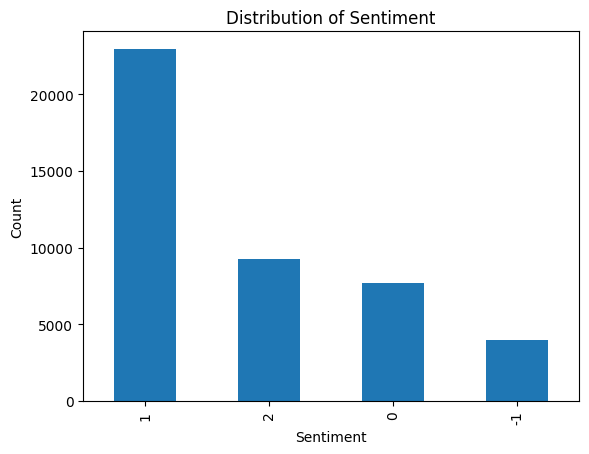

In [ ]:
# Check the distribution of the sentiment column
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment_counts.plot(kind = 'bar')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Unfortunately, there is data imbalance in the sentiment column which is going to be our target variable! While 2, 0 are nearly close to each other, 1 is 
# greatly higher than them. This means that a larger segment of tweeter users believe in climate change. I have to tackle the problem of imbalanced data 
# because it can cause serious issues for the model I am going to develop. There are some methods for this purpose. I'm going to choose cost-sensitive 
# approach; in this method, the algorithm is trained in a way with more focus on minority classes.


# Data Science)
1- Prepare the tweets to be fed into a model (BOW, TF-IDF, Word embedding). Try different models to predict the sentiment of a tweet.

In [4]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import re

# Data cleaning function:

def clean_text(text):
    text = text.lower()                 
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'@\w+', '', text)    
    text = re.sub(r'#\w+', '', text)    
    text = re.sub(r'\d+', '', text)     
    text = re.sub(r'[^\w\s]', '', text) 
    tokens = word_tokenize(text)        
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens] # Stemming
    return ' '.join(tokens)

df['cleaned_message'] = df['message'].apply(clean_text)

# Explanation: Before trying out different algorithms, text data must be preprocessed and cleaned. It means stopwords, hashtags, punctuations, URL, mentions 
# must be removed from the message column and even it must be normalized through lemmetization or stemming techniques. Once the message column is cleaned it 
# would be ready to be vectorized and after that fed into different models.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# TF-IDF)
Before applying different algorithms I must vectorize message column into numbers. In this step, I choose TF-IDF technique for vectorization. After that, I will define feature matrix & y vector. The sentiment column would be our target variable. The vectorized, cleaned message column would be the only feature matrix. Note that since the target variable has 4 unique values the problem I am trying to solve is a multi-class classification one.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(df['cleaned_message'])

# Get the vocabulary size
vocab_size = len(vectorizer.vocabulary_)
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 23934


In [16]:
# Defining feature matrix:
vectorizer = TfidfVectorizer(max_features = 23000)
X = vectorizer.fit_transform(df['cleaned_message']).toarray()

# Defining y vector:
y = df['sentiment']

In [17]:
# Splitting:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# MultinomialNB)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

class_priors = y_train.value_counts(normalize = True).sort_index().tolist() # Dealing with imbalanced data

model = MultinomialNB(class_prior = class_priors, alpha = 1.0, fit_prior = False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("F1 Score:\n", f1_score(y_test, y_pred, average = 'micro'))
print("Precision:\n", precision_score(y_test, y_pred, average = 'micro'))
print("Recall:\n", recall_score(y_test, y_pred, average = 'micro'))


F1 Score:
 0.6026851746501308
Precision:
 0.6026851746501308
Recall:
 0.6026851746501308


# LogisticRegression)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 200, multi_class = 'multinomial', solver = 'lbfgs', class_weight = 'balanced', random_state = 42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

print(f"F1 Score: {f1_score(y_test, y_pred_log_reg, average = 'micro')}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg, average = 'micro')}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg, average = 'micro')}")

# I set class_weight to 'balanced' in order to handle imbalanced data efficiently.
# Here, we can see that LogisticRegression is doing better than MultinomialNB. While F1 score of MultinomialNB is around 60%, F1 score of LogisticRegression
# is 67%. 

# What is the next?
# To improve model's performance we can do the following:
# 1) Fine tuning through methods such as GridSearchCV
# 2) Try out different methods of vectorization via word embedding methods like Word2Vec
# 3) Use more complex algorithms such as LSTM which is specifically designed for sequential data like text
# 4) After experimenting different models make a comparison between them to see which one is doing the best 


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score: 0.6745932415519399
Recall: 0.6745932415519399
Precision: 0.6745932415519399
